In [37]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [38]:
df = pd.read_csv("golf_raw.csv")

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15775 entries, 0 to 15774
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tour             15775 non-null  object 
 1   year             15775 non-null  int64  
 2   season           15775 non-null  int64  
 3   event_completed  15629 non-null  object 
 4   event_name       15775 non-null  object 
 5   player_name      15775 non-null  object 
 6   dg_id            15775 non-null  int64  
 7   fin_text         15629 non-null  object 
 8   round_num        15629 non-null  float64
 9   course_name      15629 non-null  object 
 10  course_num       15629 non-null  float64
 11  course_par       15629 non-null  float64
 12  start_hole       15629 non-null  float64
 13  teetime          15629 non-null  object 
 14  round_score      15629 non-null  float64
 15  sg_putt          11697 non-null  float64
 16  sg_arg           11697 non-null  float64
 17  sg_app      

In [40]:
df['event_name'].value_counts()

event_name
PGA Championship            3744
U.S. Open                   3567
THE PLAYERS Championship    3198
The Open Championship       2946
Masters Tournament          2320
Name: count, dtype: int64

In [41]:
# course dictionary
course_dict_df = pd.read_csv("coursename.csv")

# Create a dictionary from the course dictionary DataFrame
course_dict = dict(zip(course_dict_df['course_num'], course_dict_df['course_name']))

In [42]:
print(course_dict_df.head())

   course_num                                  course_name
0          11                                 TPC Sawgrass
1          14                   Augusta National Golf Club
2          43  The Los Angeles Country Club (North Course)
3         236                                   Erin Hills
4         241                Quail Hollow-PGA Championship


In [43]:
# player name dictionary
player_dict_df = pd.read_csv("playernames.csv")

# Create a dictionary from playername dictionary Dataframe
player_dict = dict(zip(player_dict_df['dg_id'], player_dict_df['player_name']))

In [44]:
print(player_dict_df.head())


   dg_id         player_name
0     30  Calcavecchia, Mark
1     44       Couples, Fred
2     94          Hart, Jeff
3    139         Mize, Larry
4    154       O'Meara, Mark


In [45]:
# start by dropping 'tour' column since all of the tournaments in my scope are in the same tour (PGA)
df.drop(columns = 'tour', inplace = True)

In [46]:
# drop player_name since names are stored/mapped numerically under dg_id
df.drop(columns = 'player_name', inplace = True)

In [47]:
# drop course_name since names are stored/mapped numerically under course_num
df.drop(columns = 'course_name', inplace = True)

In [48]:
# Drop granular strokes gained metrics since they are represented in sg_total
df.drop(columns=['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g'], inplace=True)

In [49]:
df.head()

,year,season,event_completed,event_name,dg_id,fin_text,round_num,course_num,course_par,start_hole,...,round_score,sg_total,driving_dist,driving_acc,gir,scrambling,prox_rgh,prox_fw,great_shots,poor_shots
0,2023,2023,3/12/23,THE PLAYERS Championship,15575,T3,3.0,11.0,72.0,10.0,...,62.0,7.573,278.8,0.786,0.889,1.000,50.571,21.302,6.0,2.0
1,2020,2021,9/20/20,U.S. Open,7881,CUT,2.0,891.0,70.0,10.0,...,86.0,-10.748,269.5,0.500,0.167,0.333,101.289,48.487,1.0,15.0
2,2020,2020,3/15/20,THE PLAYERS Championship,13562,1,1.0,11.0,72.0,10.0,...,63.0,8.301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022,2022,3/13/22,THE PLAYERS Championship,12422,T9,4.0,11.0,72.0,10.0,...,63.0,8.571,295.5,0.714,0.833,0.667,42.105,21.992,7.0,1.0
4,2024,2024,5/19/24,PGA Championship,19895,1,1.0,671.0,71.0,10.0,...,62.0,9.276,299.6,0.857,0.778,0.857,52.667,32.530,7.0,0.0


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15775 entries, 0 to 15774
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             15775 non-null  int64  
 1   season           15775 non-null  int64  
 2   event_completed  15629 non-null  object 
 3   event_name       15775 non-null  object 
 4   dg_id            15775 non-null  int64  
 5   fin_text         15629 non-null  object 
 6   round_num        15629 non-null  float64
 7   course_num       15629 non-null  float64
 8   course_par       15629 non-null  float64
 9   start_hole       15629 non-null  float64
 10  teetime          15629 non-null  object 
 11  round_score      15629 non-null  float64
 12  sg_total         15629 non-null  float64
 13  driving_dist     11555 non-null  float64
 14  driving_acc      11555 non-null  float64
 15  gir              11115 non-null  float64
 16  scrambling       11114 non-null  float64
 17  prox_rgh    

In [51]:
# Define functions to convert time to minutes
def normalize_time_format(time_str):
    return re.sub(r'(\d+:\d+)([APap][Mm])', r'\1 \2', time_str)

def time_to_minutes(time_str):
    if pd.isnull(time_str):
        return None
    time_str = normalize_time_format(time_str)
    time_obj = pd.to_datetime(time_str, format='%I:%M %p')
    return time_obj.hour * 60 + time_obj.minute

# Apply the conversion function to the 'teetime' column
df['teetime_int'] = df['teetime'].apply(time_to_minutes)

# Fill NaNs in 'teetime_int' with the median value
df['teetime_int'].fillna(df['teetime_int'].median(), inplace=True)

# List of columns to check for NaNs and calculate skewness
columns_with_nans = ['driving_dist', 'driving_acc', 'gir', 'scrambling', 
                     'prox_rgh', 'prox_fw', 'great_shots', 'poor_shots']

# Calculate skewness for the columns with NaNs
skewness = df[columns_with_nans].skew()

# Fill NaNs with mean or median based on skewness
for col in columns_with_nans:
    if abs(skewness[col]) > 1:
        # Highly skewed, use median
        df[col].fillna(df[col].median(), inplace=True)
    else:
        # Normally distributed, use mean
        df[col].fillna(df[col].mean(), inplace=True)

# Verify that there are no NaNs in the selected columns
na_counts = df[columns_with_nans].isnull().sum()
print(na_counts)

driving_dist    0
driving_acc     0
gir             0
scrambling      0
prox_rgh        0
prox_fw         0
great_shots     0
poor_shots      0
dtype: int64


In [ ]:
# convert teetime into minutes
df['teetime_int'] = df['teetime'].apply(time_to_minutes)

In [53]:
df.head()

,year,season,event_completed,event_name,dg_id,fin_text,round_num,course_num,course_par,start_hole,...,sg_total,driving_dist,driving_acc,gir,scrambling,prox_rgh,prox_fw,great_shots,poor_shots,teetime_int
0,2023,2023,3/12/23,THE PLAYERS Championship,15575,T3,3.0,11.0,72.0,10.0,...,7.573,278.800000,0.786000,0.889000,1.000000,50.571,21.302000,6.000000,2.000000,729.0
1,2020,2021,9/20/20,U.S. Open,7881,CUT,2.0,891.0,70.0,10.0,...,-10.748,269.500000,0.500000,0.167000,0.333000,101.289,48.487000,1.000000,15.000000,752.0
2,2020,2020,3/15/20,THE PLAYERS Championship,13562,1,1.0,11.0,72.0,10.0,...,8.301,289.747443,0.600082,0.604691,0.572196,56.863,35.068873,3.603239,4.325686,504.0
3,2022,2022,3/13/22,THE PLAYERS Championship,12422,T9,4.0,11.0,72.0,10.0,...,8.571,295.500000,0.714000,0.833000,0.667000,42.105,21.992000,7.000000,1.000000,737.0
4,2024,2024,5/19/24,PGA Championship,19895,1,1.0,671.0,71.0,10.0,...,9.276,299.600000,0.857000,0.778000,0.857000,52.667,32.530000,7.000000,0.000000,483.0


In [54]:
# Define bins and labels
bins = [0, 600, 720, float('inf')]
labels = [1, 2, 3] # 1 for 480-600 or 8AM-10AM, 2 for 601-720 or 10AM-12PM, 3 for anything greater than 721 or anytime after 12PM

# Create the tee_time_of_day column using pd.cut
df['tee_time_of_day'] = pd.cut(df['teetime_int'], bins=bins, labels=labels, right=False)

df['tee_time_of_day_int'] = df['tee_time_of_day'].cat.codes + 1  # Adding 1 to match the labels

In [55]:
# drop teetime since it was mapped in teetime_int and grouped in tee_time_of_day
df.drop(columns = 'teetime', inplace = True)

In [56]:
# drop tee_time_of_day since it was converted to int in another column
df.drop(columns = 'tee_time_of_day', inplace = True)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15775 entries, 0 to 15774
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 15775 non-null  int64  
 1   season               15775 non-null  int64  
 2   event_completed      15629 non-null  object 
 3   event_name           15775 non-null  object 
 4   dg_id                15775 non-null  int64  
 5   fin_text             15629 non-null  object 
 6   round_num            15629 non-null  float64
 7   course_num           15629 non-null  float64
 8   course_par           15629 non-null  float64
 9   start_hole           15629 non-null  float64
 10  round_score          15629 non-null  float64
 11  sg_total             15629 non-null  float64
 12  driving_dist         15775 non-null  float64
 13  driving_acc          15775 non-null  float64
 14  gir                  15775 non-null  float64
 15  scrambling           15775 non-null 

In [58]:
# drop event_completed since granular date of round is not needed for analysis
df.drop(columns = 'event_completed', inplace = True)

In [59]:
# drop season since granular year of round is not needed for analysis
df.drop(columns = 'season', inplace = True)

In [60]:
# Filter to include only players who completed all four rounds
def filter_complete_rounds(df):
    complete_players = df.groupby(['dg_id', 'event_name', 'year']).filter(lambda x: len(x['round_num'].unique()) == 4)
    return complete_players

# Apply the filter to the dataframe
df_complete = filter_complete_rounds(df)

# Verify the filtering
print(df_complete['dg_id'].nunique())

464


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15775 entries, 0 to 15774
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 15775 non-null  int64  
 1   event_name           15775 non-null  object 
 2   dg_id                15775 non-null  int64  
 3   fin_text             15629 non-null  object 
 4   round_num            15629 non-null  float64
 5   course_num           15629 non-null  float64
 6   course_par           15629 non-null  float64
 7   start_hole           15629 non-null  float64
 8   round_score          15629 non-null  float64
 9   sg_total             15629 non-null  float64
 10  driving_dist         15775 non-null  float64
 11  driving_acc          15775 non-null  float64
 12  gir                  15775 non-null  float64
 13  scrambling           15775 non-null  float64
 14  prox_rgh             15775 non-null  float64
 15  prox_fw              15775 non-null 

In [62]:
# Aggregating Data
aggregated_df = df_complete.groupby(['dg_id', 'event_name', 'course_num', 'year']).agg({
    'round_score': 'sum',
    'driving_dist': 'mean',
    'driving_acc': 'mean',
    'gir': 'mean',
    'scrambling': 'mean',
    'prox_rgh': 'mean',
    'prox_fw': 'mean',
    'great_shots': 'sum',
    'poor_shots': 'sum',
    'teetime_int': 'mean'
}).reset_index()

# Verify the aggregated DataFrame
print(aggregated_df.head())

# Train-Test Split
X = aggregated_df.drop(columns=['dg_id', 'round_score'])
y = aggregated_df['round_score']

# Convert categorical 'event_name', 'course_num', and 'year' to dummies
X = pd.get_dummies(X, columns=['event_name', 'course_num', 'year'], drop_first=False)

# Fill any remaining NaNs in the feature set with the median value of the respective column
X = X.fillna(X.median())

# Ensure there are no NaNs in the target variable
y = y.fillna(y.median())

# Verify no NaNs left
print(X.isnull().sum())
print(y.isnull().sum())

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Evaluate the Model
y_pred_test = reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f'Test Set Mean Squared Error: {mse_test}')
print(f'Test Set R-squared: {r2_test}')

y_pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print(f'Training Set Mean Squared Error: {mse_train}')
print(f'Training Set R-squared: {r2_train}')


   dg_id          event_name  course_num  year  round_score  driving_dist  \
0     44  Masters Tournament        14.0  2017        289.0    289.747443   
1     44  Masters Tournament        14.0  2018        291.0    289.747443   
2     44  Masters Tournament        14.0  2023        297.0    273.175000   
3    139  Masters Tournament        14.0  2017        305.0    289.747443   
4    290  Masters Tournament        14.0  2018        291.0    289.747443   

   driving_acc       gir  scrambling  prox_rgh    prox_fw  great_shots  \
0     0.600082  0.604691    0.572196   56.8630  35.068873    14.412955   
1     0.600082  0.604691    0.572196   56.8630  35.068873    14.412955   
2     0.732000  0.541500    0.534500   83.7815  45.310500     9.000000   
3     0.600082  0.604691    0.572196   56.8630  35.068873    14.412955   
4     0.600082  0.604691    0.572196   56.8630  35.068873    14.412955   

   poor_shots  teetime_int  
0   17.302744       761.00  
1   17.302744       673.50  
2   1

In [63]:
# Verify the dg_id values in the aggregated DataFrame
print(aggregated_df['dg_id'].head())

# Ensure dg_id mapping to player_name
print(aggregated_df[['dg_id']].drop_duplicates().head())

# Ensure player_dict has valid dg_id keys
invalid_keys = set(aggregated_df['dg_id']) - set(player_dict.keys())
print(f"Invalid keys: {invalid_keys}")

0     44
1     44
2     44
3    139
4    290
Name: dg_id, dtype: int64
    dg_id
0      44
3     139
4     290
8     653
13    874
Invalid keys: set()


In [64]:
def list_available_entries():
    # List available event names
    available_event_names = aggregated_df['event_name'].unique()
    print("Available event names:")
    for event in available_event_names:
        print(event)

    # List available years in chronological order
    available_years = sorted(aggregated_df['year'].unique())
    print("\nAvailable years (in chronological order):")
    for year in available_years:
        print(year)


In [73]:
def predict_leaderboard(event_name, year):
    # Filter the data for the specific event and year
    event_data = aggregated_df[(aggregated_df['event_name'] == event_name) & (aggregated_df['year'] == year)]
    
    # Ensure only players who completed all four rounds are included
    event_data = event_data.groupby('dg_id').filter(lambda x: len(x['round_score']) == 1)

    # Check if event_data is empty
    if event_data.empty:
        print(f"No data found for event: {event_name} and year: {year}")
        return None

    # Prepare the features
    event_features = event_data.drop(columns=['dg_id', 'round_score'])
    event_features = pd.get_dummies(event_features, columns=['event_name', 'course_num', 'year'], drop_first=False)
    event_features = event_features.reindex(columns=X.columns, fill_value=0)

    # Fill any remaining NaNs in the feature set with the median value of the respective column
    event_features = event_features.fillna(event_features.median())

    # Predict the scores
    event_data['predicted_score'] = reg.predict(event_features)
    
    # Sort players by predicted score to simulate a leaderboard
    predicted_leaderboard = event_data.sort_values(by='predicted_score').reset_index(drop=True)
    
    # Add player names using the player dictionary
    predicted_leaderboard['player_name'] = predicted_leaderboard['dg_id'].map(player_dict)
    
    # Select relevant columns and show top 10 players
    predicted_leaderboard = predicted_leaderboard[['dg_id', 'player_name', 'event_name', 'year', 'predicted_score']].head(5)
    
    return predicted_leaderboard

def get_actual_top_5(event_name, year):
    # Filter the data for the specific event and year
    actual_data = df[(df['event_name'] == event_name) & (df['year'] == year)]
    
    # Ensure only players who completed all four rounds are included
    actual_data = actual_data.groupby('dg_id').filter(lambda x: len(x['round_num'].unique()) == 4)
    
    # Aggregate the data to get the total round score for each player
    actual_data = actual_data.groupby(['dg_id', 'event_name', 'year']).agg({
        'round_score': 'sum'
    }).reset_index()
    
    # Sort by round_score to get the top 5 players
    actual_top_5 = actual_data.sort_values(by='round_score').head(5)
    
    # Add player names using the player dictionary
    actual_top_5['player_name'] = actual_top_5['dg_id'].map(player_dict)
    
    # Reorder columns to match the predicted leaderboard format
    actual_top_5 = actual_top_5[['dg_id', 'player_name', 'event_name', 'year', 'round_score']]
    
    return actual_top_5


In [78]:
def calculate_percentage_correct(predicted_df, actual_df):
    # Get the dg_id values from both DataFrames
    predicted_ids = set(predicted_df['dg_id'])
    actual_ids = set(actual_df['dg_id'])
    
    # Calculate the intersection of predicted and actual dg_id values
    correct_predictions = predicted_ids.intersection(actual_ids)
    
    # Calculate the percentage of correct predictions
    percentage_correct = (len(correct_predictions) / len(actual_ids)) * 100
    
    return percentage_correct

# List available entries
list_available_entries()

# Example: Predict leaderboard for a previous event
event_name = "PGA Championship"
year = 2024
leaderboard_prev = predict_leaderboard(event_name, year)
if leaderboard_prev is not None:
    # Round the predicted scores
    leaderboard_prev['predicted_score'] = leaderboard_prev['predicted_score'].round()
    print("\nPredicted Leaderboard:")
    display(leaderboard_prev)

# Retrieve actual top 5 players for a previous event
actual_top_5_prev = get_actual_top_5(event_name, year)
if actual_top_5_prev is not None:
    print("\nActual Top 5 Leaderboard:")
    display(actual_top_5_prev)

# Calculate the percentage of correct predictions
if leaderboard_prev is not None and actual_top_5_prev is not None:
    percentage_correct = calculate_percentage_correct(leaderboard_prev, actual_top_5_prev)
    print(f"\nPercentage of Correct Predictions: {percentage_correct:.2f}%")


Available event names:
Masters Tournament
The Open Championship
PGA Championship
THE PLAYERS Championship
U.S. Open

Available years (in chronological order):
2017
2018
2019
2020
2021
2022
2023
2024

Predicted Leaderboard:


,dg_id,player_name,event_name,year,predicted_score
0,19895,"Schauffele, Xander",PGA Championship,2024,266.0
1,19841,"DeChambeau, Bryson",PGA Championship,2024,266.0
2,18841,"Hovland, Viktor",PGA Championship,2024,267.0
3,11676,"Finau, Tony",PGA Championship,2024,270.0
4,23323,"MacIntyre, Robert",PGA Championship,2024,271.0



Actual Top 5 Leaderboard:


,dg_id,player_name,event_name,year,round_score
60,19895,"Schauffele, Xander",PGA Championship,2024,263.0
59,19841,"DeChambeau, Bryson",PGA Championship,2024,264.0
57,18841,"Hovland, Viktor",PGA Championship,2024,266.0
24,14181,"Detry, Thomas",PGA Championship,2024,269.0
65,22085,"Morikawa, Collin",PGA Championship,2024,269.0



Percentage of Correct Predictions: 60.00%


In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the events and years to be used in the loop
events = [
    "Masters Tournament",
    "The Open Championship",
    "PGA Championship",
    "THE PLAYERS Championship",
    "U.S. Open"
]
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

# Function to calculate percentage correct based on top 5
def calculate_percentage_correct(predicted_df, actual_df):
    # Get the dg_id values from both DataFrames
    predicted_ids = set(predicted_df['dg_id'])
    actual_ids = set(actual_df['dg_id'])
    
    # Calculate the intersection of predicted and actual dg_id values
    correct_predictions = predicted_ids.intersection(actual_ids)
    
    # Calculate the percentage of correct predictions
    percentage_correct = (len(correct_predictions) / len(actual_ids)) * 100
    
    return percentage_correct

# Create the output directory if it doesn't exist
os.makedirs("output", exist_ok=True)

# Initialize a list to store the summary results
summary_results = []

# Loop through each year and event
for year in years:
    for event in events:
        # Skip specific combinations
        if (year == 2020 and event in ["Masters Tournament", "The Open Championship", "THE PLAYERS Championship"]) or (year == 2024 and event == "The Open Championship"):
            continue
        
        # Predict leaderboard for the event and year
        leaderboard_prev = predict_leaderboard(event, year)
        actual_top_5_prev = get_actual_top_5(event, year)
        
        # Calculate the percentage of correct predictions
        if leaderboard_prev is not None and actual_top_5_prev is not None:
            # Round the predicted scores
            leaderboard_prev['predicted_score'] = leaderboard_prev['predicted_score'].round()

            percentage_correct = calculate_percentage_correct(leaderboard_prev, actual_top_5_prev)
            summary_results.append({
                "Year": year,
                "Event": event,
                "Percentage Correct": percentage_correct
            })
            
            # Ensure the DataFrames have the correct columns
            leaderboard_prev['event_name'] = event
            leaderboard_prev['year'] = year
            actual_top_5_prev['event_name'] = event
            actual_top_5_prev['year'] = year

            # Create a figure for the predicted and actual leaderboards
            fig, axes = plt.subplots(3, 1, figsize=(10, 15))

            # Plot predicted leaderboard
            axes[0].axis('off')
            axes[0].table(cellText=leaderboard_prev.head(5).values, colLabels=leaderboard_prev.columns, cellLoc='center', loc='center')
            axes[0].set_title(f"Predicted Leaderboard: {event} {year}")

            # Plot actual leaderboard
            axes[1].axis('off')
            axes[1].table(cellText=actual_top_5_prev.values, colLabels=actual_top_5_prev.columns, cellLoc='center', loc='center')
            axes[1].set_title(f"Actual Top 5 Leaderboard: {event} {year}")

            # Plot percentage correct
            axes[2].axis('off')
            axes[2].text(0.5, 0.5, f"Percentage of Correct Predictions: {percentage_correct:.2f}%", horizontalalignment='center', verticalalignment='center', fontsize=15)
            axes[2].set_title(f"Prediction Accuracy: {event} {year}")

            # Save the figure
            plt.tight_layout()
            output_file = f"output/{year}{event.replace(' ', '')}.png"
            plt.savefig(output_file)
            plt.close()

print("Results saved to the output folder as images.")


Results saved to the output folder as images.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


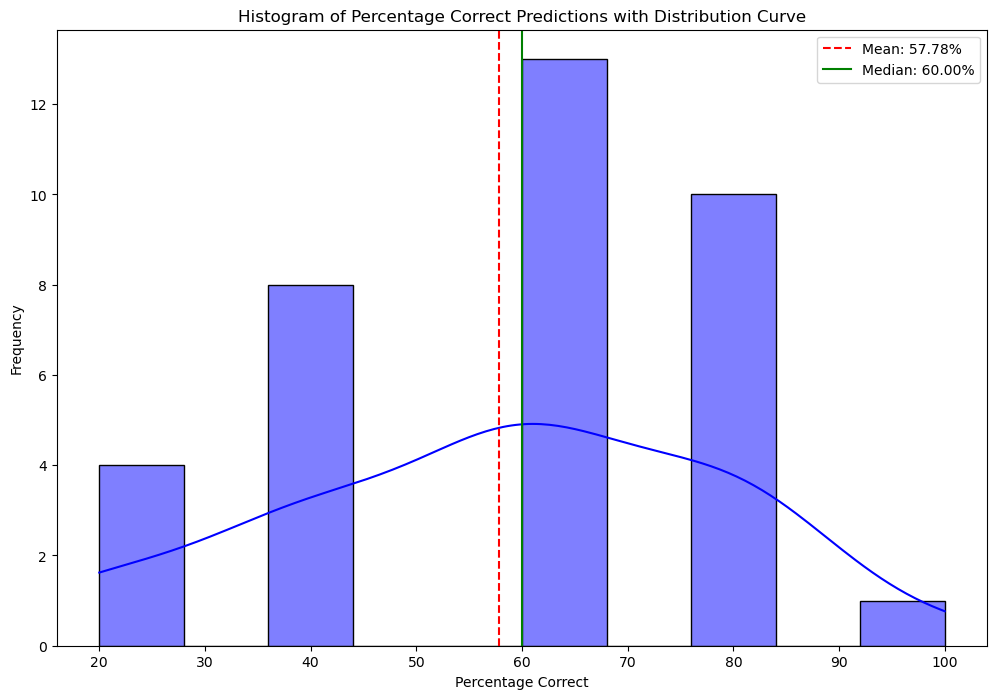

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the events and years to be used in the loop
events = [
    "Masters Tournament",
    "The Open Championship",
    "PGA Championship",
    "THE PLAYERS Championship",
    "U.S. Open"
]
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

# Function to calculate percentage correct based on top 5
def calculate_percentage_correct(predicted_df, actual_df):
    # Get the dg_id values from both DataFrames
    predicted_ids = set(predicted_df['dg_id'])
    actual_ids = set(actual_df['dg_id'])
    
    # Calculate the intersection of predicted and actual dg_id values
    correct_predictions = predicted_ids.intersection(actual_ids)
    
    # Calculate the percentage of correct predictions
    percentage_correct = (len(correct_predictions) / len(actual_ids)) * 100
    
    return percentage_correct

# Initialize a list to store the percentage correct results
percentage_correct_list = []

# Loop through each year and event
for year in years:
    for event in events:
        # Skip specific combinations
        if (year == 2020 and event in ["Masters Tournament", "The Open Championship", "THE PLAYERS Championship"]) or (year == 2024 and event == "The Open Championship"):
            continue
        
        # Predict leaderboard for the event and year
        leaderboard_prev = predict_leaderboard(event, year)
        actual_top_5_prev = get_actual_top_5(event, year)
        
        # Calculate the percentage of correct predictions
        if leaderboard_prev is not None and actual_top_5_prev is not None:
            # Round the predicted scores
            leaderboard_prev['predicted_score'] = leaderboard_prev['predicted_score'].round()

            percentage_correct = calculate_percentage_correct(leaderboard_prev, actual_top_5_prev)
            percentage_correct_list.append(percentage_correct)

# Plot histogram of the percentage correct
plt.figure(figsize=(12, 8))
sns.histplot(percentage_correct_list, bins=10, kde=True, color='blue', edgecolor='black')

# Calculate mean and median
mean_val = np.mean(percentage_correct_list)
median_val = np.median(percentage_correct_list)

# Add vertical lines for mean and median
plt.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.2f}%')
plt.axvline(median_val, color='green', linestyle='-', linewidth=1.5, label=f'Median: {median_val:.2f}%')

# Add title and labels
plt.title('Histogram of Percentage Correct Predictions with Distribution Curve')
plt.xlabel('Percentage Correct')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Display the plot
plt.show()


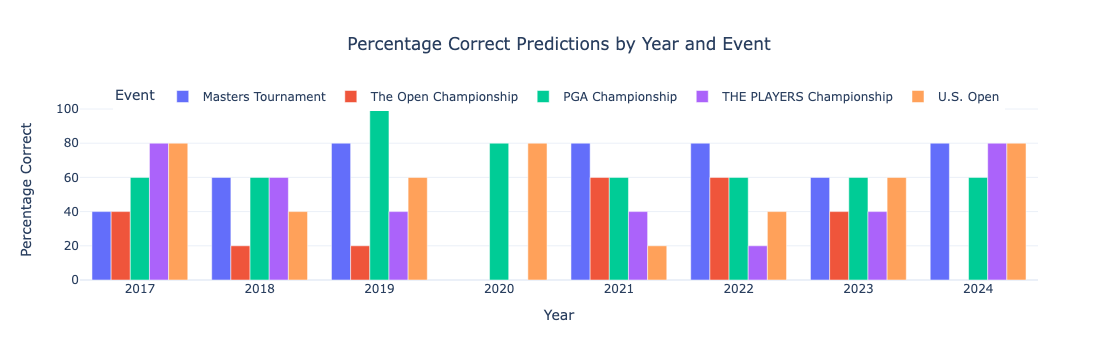

In [84]:
import pandas as pd
import plotly.express as px

# Define the events and years to be used in the loop
events = [
    "Masters Tournament",
    "The Open Championship",
    "PGA Championship",
    "THE PLAYERS Championship",
    "U.S. Open"
]
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

# Function to calculate percentage correct based on top 5
def calculate_percentage_correct(predicted_df, actual_df):
    # Get the dg_id values from both DataFrames
    predicted_ids = set(predicted_df['dg_id'])
    actual_ids = set(actual_df['dg_id'])
    
    # Calculate the intersection of predicted and actual dg_id values
    correct_predictions = predicted_ids.intersection(actual_ids)
    
    # Calculate the percentage of correct predictions
    percentage_correct = (len(correct_predictions) / len(actual_ids)) * 100
    
    return percentage_correct

# Initialize a list to store the results
results = []

# Loop through each year and event
for year in years:
    for event in events:
        # Skip specific combinations
        if (year == 2020 and event in ["Masters Tournament", "The Open Championship", "THE PLAYERS Championship"]) or (year == 2024 and event == "The Open Championship"):
            continue
        
        # Predict leaderboard for the event and year
        leaderboard_prev = predict_leaderboard(event, year)
        actual_top_5_prev = get_actual_top_5(event, year)
        
        # Calculate the percentage of correct predictions
        if leaderboard_prev is not None and actual_top_5_prev is not None:
            # Round the predicted scores
            leaderboard_prev['predicted_score'] = leaderboard_prev['predicted_score'].round()

            percentage_correct = calculate_percentage_correct(leaderboard_prev, actual_top_5_prev)
            results.append({
                "Year": year,
                "Event": event,
                "Percentage Correct": percentage_correct
            })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Create the bar plot with Plotly Express
fig = px.bar(
    results_df,
    x="Year",
    y="Percentage Correct",
    color="Event",
    barmode="group",
    title="Percentage Correct Predictions by Year and Event",
    labels={"Percentage Correct": "Percentage Correct", "Year": "Year"},
    template="plotly_white"
)

# Update the layout to make it look better
fig.update_layout(
    title={'x': 0.5, 'xanchor': 'center'},
    legend=dict(title="Event", orientation="h", y=1.1, x=0.5, xanchor='center')
)

# Show the plot
fig.show()
